In [420]:
import math
import time
from copy import deepcopy
import dill as pickle
import IPython.display as IPd
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import torch
from matplotlib import ticker
from pyloric import create_prior, simulate, summary_stats
from pyloric.utils import energy_of_membrane, energy_of_synapse
from sbi.analysis import ActiveSubspace

import stg_energy.fig3_active_subspaces.viz as viz
from stg_energy.fig3_active_subspaces.helper_functions import nth_argmax, nth_argmin

# Figure 3

In [421]:
pd.options.display.max_columns = 999

In [422]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [423]:
PANEL_MECH_KD_A = "../svg/panel_mech_kd_a.svg"
PANEL_MECH_KD_B = "../svg/panel_mech_kd_b.svg"
PANEL_MECH_KD_C = "../svg/panel_mech_kd_c.svg"
PANEL_MECH_KD_D = "../svg/panel_mech_kd_d.svg"
PANEL_MECH_KD_E = "../svg/panel_mech_kd_e.svg"
PANEL_MECH_KD_F = "../svg/panel_mech_kd_f.svg"
PANEL_MECH_KD_voltage = "../svg/panel_mech_kd_voltage.svg"

### Load experimental data

In [424]:
prior_11 = create_prior()

In [425]:
theta = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_circuit_parameters.pkl"
)
x = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_simulation_outputs.pkl"
)
seeds = np.load(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_seeds.npy"
)

theta_np = theta.to_numpy()
x_np = x.to_numpy()

### Time vector

In [426]:
t = np.arange(0, 11000, 0.025)

### Doubling Na leads to twice as high effective conductances

In [427]:
from pyloric.utils import show_traces

In [428]:
custom_stats = {
    "plateau_durations": True,
    "num_bursts": True,
    "num_spikes": True,
    "energies": True,
    "energies_per_burst": True,
    "energies_per_spike": True,
    "pyloric_like": True,
}

In [429]:
out_target_base = simulate(theta.loc[0], seed=int(seeds[0]), track_energy=True, track_currents=True)
summstats_base = summary_stats(out_target_base, stats_customization=custom_stats)

In [430]:
print("Energy consumption of PY:              ", int(summstats_base["energies"]["PY"].loc[0]))
print("Num spikes of PY:                      ", int(summstats_base["num_spikes"]["PY"].loc[0]))
print("Energy consumption per spike of PY:    ", int(summstats_base["energies_per_spike"]["PY"].loc[0]))

Energy consumption of PY:               85106
Num spikes of PY:                       197
Energy consumption per spike of PY:     429


In [431]:
perturbed_theta = deepcopy(theta.loc[0])
perturbed_theta["PY"]["Na"] += 300.0

In [432]:
out_target = simulate(perturbed_theta, seed=int(seeds[0]), track_energy=True, track_currents=True)
summstats = summary_stats(out_target, stats_customization=custom_stats)

In [433]:
print("Energy consumption of PY:              ", int(summstats["energies"]["PY"].loc[0]))
print("Num spikes of PY:                      ", int(summstats["num_spikes"]["PY"].loc[0]))
print("Energy consumption per spike of PY:    ", int(summstats["energies_per_spike"]["PY"].loc[0]))

Energy consumption of PY:               129913
Num spikes of PY:                       168
Energy consumption per spike of PY:     770


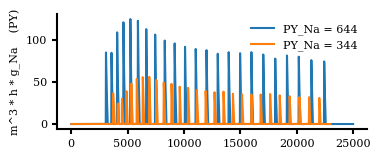

In [434]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(4, 1.5))
    _ = ax.plot(out_target["membrane_conds"][2, 0, 65000:90000])
    _ = ax.plot(out_target_base["membrane_conds"][2, 0, 66000:89000])
    ax.set_ylabel("m^3 * h * g_Na    (PY)")
    ax.legend([f"PY_Na = {int(perturbed_theta['PY']['Na'])}", f"PY_Na = {int(theta.loc[0]['PY']['Na'])}"])
    plt.savefig(PANEL_MECH_KD_A, facecolor="None", transparent=True)

### ...but doubling Kd does not

In [435]:
perturbed_theta = deepcopy(theta.loc[0])
perturbed_theta["PY"]["Kd"] += 40.0

In [436]:
out_target = simulate(perturbed_theta, seed=int(seeds[0]), track_energy=True, track_currents=True)
summstats = summary_stats(out_target, stats_customization=custom_stats)

In [437]:
print("Energy consumption of PY:              ", int(summstats["energies"]["PY"].loc[0]))
print("Num spikes of PY:                      ", int(summstats["num_spikes"]["PY"].loc[0]))
print("Energy consumption per spike of PY:    ", int(summstats["energies_per_spike"]["PY"].loc[0]))

Energy consumption of PY:               80097
Num spikes of PY:                       180
Energy consumption per spike of PY:     442


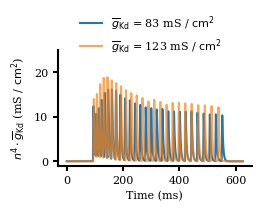

In [438]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2.5, 1.5))
    _ = ax.plot(t[:91500-66500], out_target_base["membrane_conds"][2, 5, 66000:91000])
    _ = ax.plot(t[:91500-66500], out_target["membrane_conds"][2, 5, 66500:91500], alpha=0.7)
    ax.set_ylabel("$n^4 \cdot \overline{g}_{\mathrm{Kd}}$ (mS / $\mathrm{cm}^2$)")
    ax.set_xlabel("Time (ms)")
    ax.legend(
        [
            "$\overline{g}_{\mathrm{Kd}}$"+f" = {int(theta.loc[0]['PY']['Kd'])}" + " mS / $\mathrm{cm}^2$", 
            "$\overline{g}_{\mathrm{Kd}}$"+f" = {int(perturbed_theta['PY']['Kd'])}" + " mS / $\mathrm{cm}^2$"
        ], 
        bbox_to_anchor=(0.48, 1.4), 
        loc='upper center', 
        labelspacing=0.4
    )
    ax.set_ylim([-1, 25])
    plt.savefig(PANEL_MECH_KD_B, facecolor="None", transparent=True)

### Plot only n

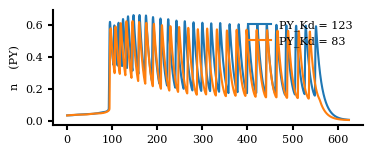

In [439]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(4, 1.5))
    _ = ax.plot(t[:91500-66500], out_target_base["n_Kd"][2, 66000:91000])
    _ = ax.plot(t[:91500-66500], out_target["n_Kd"][2, 66500:91500])
    ax.set_ylabel("n    (PY)")
    ax.legend([f"PY_Kd = {int(perturbed_theta['PY']['Kd'])}", f"PY_Kd = {int(theta.loc[0]['PY']['Kd'])}"])
    plt.savefig(PANEL_MECH_KD_C, facecolor="None", transparent=True)

### ...and plot n**4

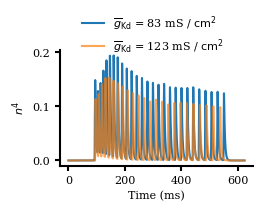

In [440]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2.5, 1.5))
    _ = ax.plot(t[:91500-66500], out_target_base["n_Kd"][2, 66000:91000]**4)
    _ = ax.plot(t[:91500-66500], out_target["n_Kd"][2, 66500:91500]**4, alpha=0.7)
    ax.set_ylabel("$n^4$")
    ax.set_xlabel("Time (ms)")
    ax.legend(
        [
            "$\overline{g}_{\mathrm{Kd}}$"+f" = {int(theta.loc[0]['PY']['Kd'])}" + " mS / $\mathrm{cm}^2$", 
            "$\overline{g}_{\mathrm{Kd}}$"+f" = {int(perturbed_theta['PY']['Kd'])}" + " mS / $\mathrm{cm}^2$"
        ], 
        bbox_to_anchor=(0.48, 1.4), 
        loc='upper center', 
        labelspacing=0.4
    )
    plt.savefig(PANEL_MECH_KD_D, facecolor="None", transparent=True)

### Plot voltages in both scenarios: they have the same peeks

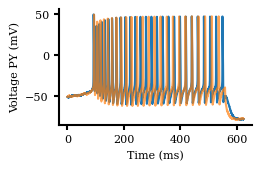

In [441]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2.5, 1.5))
    _ = ax.plot(t[:91500-66500], out_target_base["voltage"][2, 66000:91000])
    _ = ax.plot(t[:91500-66500], out_target["voltage"][2, 66500:91500], alpha=0.7)
    ax.set_ylabel("Voltage PY (mV)")
    ax.set_xlabel("Time (ms)")
#     ax.legend([f"PY_Na = {int(perturbed_theta['PY']['Kd'])}", f"PY_Na = {int(theta.loc[0]['PY']['Kd'])}"])
    plt.savefig(PANEL_MECH_KD_voltage, facecolor="None", transparent=True)

### Now increase sodium

In [442]:
perturbed_theta = deepcopy(theta.loc[0])
perturbed_theta["PY"]["Na"] += 200.0

In [443]:
out_target = simulate(perturbed_theta, seed=int(seeds[0]), track_energy=True, track_currents=True)
summstats = summary_stats(out_target, stats_customization=custom_stats)

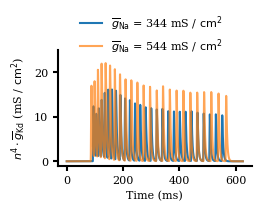

In [444]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2.5, 1.5))
    _ = ax.plot(t[:91500-66500], out_target_base["membrane_conds"][2, 5, 66000:91000])
    _ = ax.plot(t[:91500-66500], out_target["membrane_conds"][2, 5, 65000:90000], alpha=0.7)
    ax.set_ylabel("$n^4 \cdot \overline{g}_{\mathrm{Kd}}$ (mS / $\mathrm{cm}^2$)")
    ax.set_xlabel("Time (ms)")
    ax.legend(
        [
            "$\overline{g}_{\mathrm{Na}}$"+f" = {int(theta.loc[0]['PY']['Na'])}" + " mS / $\mathrm{cm}^2$", 
            "$\overline{g}_{\mathrm{Na}}$"+f" = {int(perturbed_theta['PY']['Na'])}" + " mS / $\mathrm{cm}^2$"
        ], 
        bbox_to_anchor=(0.48, 1.4), 
        loc='upper center', 
        labelspacing=0.4
    )
    ax.set_ylim([-1, 25])
    plt.savefig(PANEL_MECH_KD_voltage, facecolor="None", transparent=True)

### Plot overlap between voltage and n: With stronger Kd, the spikes are more narrow because there is more Kd influx. Thus, the n gate gits closed after a shorter time. Thus, the n gate never reaches a high value. Thus, n**4*g_Kd never gets as high

In [445]:
offset = 10000

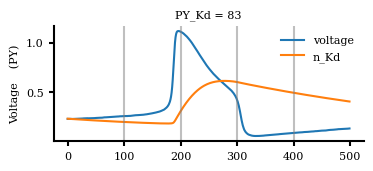

In [446]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(4, 1.5))
    _ = ax.plot((out_target_base["voltage"][2, offset+69300:offset+69800] + 65) / 100)
    _ = ax.plot(out_target_base["n_Kd"][2, offset+69300:offset+69800])
    ax.set_ylabel("Voltage    (PY)")
    ax.legend(["voltage", "n_Kd"])
    ax.set_title(f"PY_Kd = {int(theta.loc[0]['PY']['Kd'])}")
    ax.axvline(100, color="grey", alpha=0.5)
    ax.axvline(200, color="grey", alpha=0.5)
    ax.axvline(300, color="grey", alpha=0.5)
    ax.axvline(400, color="grey", alpha=0.5)
    plt.savefig(PANEL_MECH_KD_E, facecolor="None", transparent=True)

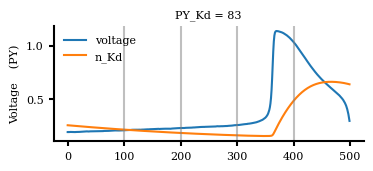

In [447]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(4, 1.5))
    _ = ax.plot((out_target["voltage"][2, offset+71100:offset+71600] + 65) / 100)
    _ = ax.plot(out_target["n_Kd"][2, offset+71100:offset+71600])
    ax.set_ylabel("Voltage    (PY)")
    ax.legend(["voltage", "n_Kd"])
    ax.set_title(f"PY_Kd = {int(perturbed_theta['PY']['Kd'])}")
    ax.axvline(100, color="grey", alpha=0.5)
    ax.axvline(200, color="grey", alpha=0.5)
    ax.axvline(300, color="grey", alpha=0.5)
    ax.axvline(400, color="grey", alpha=0.5)
    plt.savefig(PANEL_MECH_KD_F,facecolor="None", transparent=True)

In [448]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [449]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_blue = {'size': '7.7pt', 'font': 'Arial', 'weight': '500', 'color': "#0570b0"}

f = Figure("20.3cm", "4.7cm",
    Panel(
          SVG(PANEL_MECH_KD_voltage).scale(svg_scale).move(0, 0*factor_svg),
    ).move(0*factor_svg, -1.4*factor_svg),
           
    Panel(
          SVG(PANEL_MECH_KD_D).scale(svg_scale).move(0, 0*factor_svg),
    ).move(95*factor_svg, -1.4*factor_svg),

    Panel(
          SVG(PANEL_MECH_KD_B).scale(svg_scale).move(0, 0*factor_svg),
    ).move(48*factor_svg, -1.4*factor_svg),        
)

!mkdir -p fig
f.save("../fig/fig3_supp9.svg")
svg('../fig/fig3_supp9.svg')

### Full figure

In [450]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_blue = {'size': '7.7pt', 'font': 'Arial', 'weight': '500', 'color': "#0570b0"}

f = Figure("20.3cm", "13.8cm",

    Panel(
          SVG(PANEL_MECH_KD_A).scale(svg_scale).move(0, 0*factor_svg),
        Text("a", -5.0*factor_svg, -4.5*factor_svg, **kwargs_text),
    ).move(5*factor_svg, 4*factor_svg),
           
    Panel(
          SVG(PANEL_MECH_KD_B).scale(svg_scale).move(0, 0*factor_svg),
    ).move(75*factor_svg, 4*factor_svg),
           
    Panel(
          SVG(PANEL_MECH_KD_C).scale(svg_scale).move(0, 0*factor_svg),
        Text("b", -5.0*factor_svg, -4.5*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 34*factor_svg),
           
    Panel(
          SVG(PANEL_MECH_KD_D).scale(svg_scale).move(0, 0*factor_svg),
    ).move(75*factor_svg, 34*factor_svg),
           
    Panel(
          SVG(PANEL_MECH_KD_E).scale(svg_scale).move(0, 0*factor_svg),
        Text("c", -5.0*factor_svg, -4.5*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 64*factor_svg),
           
    Panel(
          SVG(PANEL_MECH_KD_F).scale(svg_scale).move(0, 0*factor_svg),
    ).move(75*factor_svg, 64*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig3_mech_exp.svg")
svg('../fig/fig3_mech_exp.svg')